In [76]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import unicodedata
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Documentation:

* nltk: https://www.nltk.org/
* Textblob: https://textblob.readthedocs.io/en/dev/
* wordcloud: https://amueller.github.io/word_cloud/

In [77]:
data = pd.read_csv('../data/Categories and prompts and ratings.csv')
data.head()

,Topic,Prompt Nr,Prompt,Model,Actual Model (Fill in after Rating is complete),Response,Rating Christine,Comments Christine,Rating Ansam,Comment Ansam,Rating Adrian,Comment Adrian,Rating Mike,Comment Mike,Rating Albin,Comment Albin,Rating Grzegorz,Comment Grzegorz,Translation Language,Translation Type
0,Creativity (Christine),1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,"Creative, I know what it's talking about",7.0,"Structure matches, feels bland though",8.0,"Is a Haiku, nice!",8.0,first 2 lines really good.,7.0,Nice wording,NaN,NaN
1,NaN,NaN,NaN,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,"Structure matches, can't judge it really",4.0,"Not quite Haiku, not so specific",6.0,unclear,6.0,Just ok,NaN,NaN
2,NaN,NaN,NaN,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,"Creative, accurate, made me smile",4.0,"Structure mismatch, I don't get it",3.0,"Not quite Haiku, too long",4.0,incorrect format,10.0,"The best in this category. Creative, funny",NaN,NaN
3,NaN,NaN,NaN,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,"Structure matches, but feels basic",9.0,"Is a Haiku, focuses on fork, really like this",7.0,good wording,8.0,"Nice wording, creative",NaN,NaN
4,NaN,NaN,NaN,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,"Structure mismatch, feels clumsy",7.0,"Is a Haiku, like this one too",4.0,incorrect format,5.0,The worst in this category. Boring,NaN,NaN


# Data cleaning

In [78]:
data.columns

Index(['Topic', 'Prompt Nr', 'Prompt', 'Model',
       'Actual Model (Fill in after Rating is complete)', 'Response',
       'Rating Christine', 'Comments Christine', 'Rating Ansam',
       'Comment Ansam', 'Rating Adrian', 'Comment Adrian', 'Rating Mike',
       'Comment Mike', 'Rating Albin', 'Comment Albin', 'Rating Grzegorz',
       'Comment Grzegorz', 'Translation Language', 'Translation Type'],
      dtype='object')

In [79]:
# filling the empty columns with missing data about topics, pormpt number and prompt
data['Topic'].fillna(method='ffill', inplace=True)
data['Prompt Nr'].fillna(method='ffill', inplace=True)
data['Prompt'].fillna(method='ffill', inplace=True)

In [80]:
# replace space with _ for column names for easier coding

data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['Topic', 'Prompt_Nr', 'Prompt', 'Model',
       'Actual_Model_(Fill_in_after_Rating_is_complete)', 'Response',
       'Rating_Christine', 'Comments_Christine', 'Rating_Ansam',
       'Comment_Ansam', 'Rating_Adrian', 'Comment_Adrian', 'Rating_Mike',
       'Comment_Mike', 'Rating_Albin', 'Comment_Albin', 'Rating_Grzegorz',
       'Comment_Grzegorz', 'Translation_Language', 'Translation_Type'],
      dtype='object')

In [81]:
# delete rows where there is no prompt or prompt number 

data = data.dropna(subset=['Model', 'Actual_Model_(Fill_in_after_Rating_is_complete)'], how='all')
data.head(5)

,Topic,Prompt_Nr,Prompt,Model,Actual_Model_(Fill_in_after_Rating_is_complete),Response,Rating_Christine,Comments_Christine,Rating_Ansam,Comment_Ansam,Rating_Adrian,Comment_Adrian,Rating_Mike,Comment_Mike,Rating_Albin,Comment_Albin,Rating_Grzegorz,Comment_Grzegorz,Translation_Language,Translation_Type
0,Creativity (Christine),1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,"Creative, I know what it's talking about",7.0,"Structure matches, feels bland though",8.0,"Is a Haiku, nice!",8.0,first 2 lines really good.,7.0,Nice wording,NaN,NaN
1,Creativity (Christine),1.0,Write a Haiku about a fork,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,"Structure matches, can't judge it really",4.0,"Not quite Haiku, not so specific",6.0,unclear,6.0,Just ok,NaN,NaN
2,Creativity (Christine),1.0,Write a Haiku about a fork,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,"Creative, accurate, made me smile",4.0,"Structure mismatch, I don't get it",3.0,"Not quite Haiku, too long",4.0,incorrect format,10.0,"The best in this category. Creative, funny",NaN,NaN
3,Creativity (Christine),1.0,Write a Haiku about a fork,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,"Structure matches, but feels basic",9.0,"Is a Haiku, focuses on fork, really like this",7.0,good wording,8.0,"Nice wording, creative",NaN,NaN
4,Creativity (Christine),1.0,Write a Haiku about a fork,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,"Structure mismatch, feels clumsy",7.0,"Is a Haiku, like this one too",4.0,incorrect format,5.0,The worst in this category. Boring,NaN,NaN


In [82]:
data = data.rename(columns={'Actual_Model_(Fill_in_after_Rating_is_complete)': 'Model_Name'})

Cleaning for sentiment analysis

In [83]:
# text cleaning 
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text) 
    return text

def clean_text(text):
    text = re.sub(r"@[A-Za-z0–9]+", "", text) # Remove @mentions replace with blank
    text = re.sub(r"#", "", text) # Remove the ‘#’ symbol, replace with blank
    text = re.sub(r"RT[\s]+", "", text) # Removing RT, replace with blank
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove the hyperlinks
    text = re.sub(r":", "", text) # Remove :
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [84]:
def clean_column(df, column_name):
    df[column_name] = df[column_name].apply(remove_accented_chars)
    df[column_name] = df[column_name].apply(remove_special_characters)
    df[column_name] = df[column_name].apply(clean_text)
    df[column_name] = df[column_name].apply(remove_emojis)
    return df

In [85]:
# this will be used for the word cloud

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [86]:
for colname in ['Comments_Christine', 'Comment_Ansam', 'Comment_Adrian', 'Comment_Mike', 'Comment_Albin', 'Comment_Grzegorz']:
    data[colname] = data[colname].replace(np.nan, 'No comment')
    data = clean_column(data, colname)

# Calculations

### Average rating for each prompt

In [87]:
data['Average_rating'] = data[['Rating_Christine', 'Rating_Ansam', 'Rating_Adrian', 'Rating_Mike', 'Rating_Albin', 'Rating_Grzegorz']].mean(axis=1)
data.head()

,Topic,Prompt_Nr,Prompt,Model,Model_Name,Response,Rating_Christine,Comments_Christine,Rating_Ansam,Comment_Ansam,Rating_Adrian,Comment_Adrian,Rating_Mike,Comment_Mike,Rating_Albin,Comment_Albin,Rating_Grzegorz,Comment_Grzegorz,Translation_Language,Translation_Type,Average_rating
0,Creativity (Christine),1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,Creative I know what its talking about,7.0,Structure matches feels bland though,8.0,Is a Haiku nice,8.0,first 2 lines really good,7.0,Nice wording,NaN,NaN,7.500000
1,Creativity (Christine),1.0,Write a Haiku about a fork,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,Structure matches cant judge it really,4.0,Not quite Haiku not so specific,6.0,unclear,6.0,Just ok,NaN,NaN,5.500000
2,Creativity (Christine),1.0,Write a Haiku about a fork,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,Creative accurate made me smile,4.0,Structure mismatch I dont get it,3.0,Not quite Haiku too long,4.0,incorrect format,10.0,The best in this category Creative funny,NaN,NaN,5.666667
3,Creativity (Christine),1.0,Write a Haiku about a fork,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,Structure matches but feels basic,9.0,Is a Haiku focuses on fork really like this,7.0,good wording,8.0,Nice wording creative,NaN,NaN,7.833333
4,Creativity (Christine),1.0,Write a Haiku about a fork,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,Structure mismatch feels clumsy,7.0,Is a Haiku like this one too,4.0,incorrect format,5.0,The worst in this category Boring,NaN,NaN,5.000000


### Group by topic

In [88]:
data_gb_topic = data.groupby('Topic').agg({'Average_rating':'mean'}).reset_index()
data_gb_topic

,Topic,Average_rating
0,Creativity (Christine),6.444444
1,Idea Generation (Albin),7.166667
2,Intuitive Physics (Mike),6.666667
3,Math (Ansam),6.082222
4,Theory of Mind (Adrian),7.800000
5,Translation (Grzegorz),6.457143


### Group by Model

In [89]:
data_gb_model = data.groupby('Model_Name').agg({'Average_rating':'mean'}).reset_index()
data_gb_model

,Model_Name,Average_rating
0,ChatGPT 3.5,6.675000
1,ChatGPT 4,7.694167
2,Gemini,7.008333
3,Gemini Advanced,7.005833
4,LLaMA 70b,4.101667


# Visualizations

How did models in general do in each topic?

In [90]:
fig = px.bar(data_gb_topic, x='Topic', y='Average_rating', 
             title='Average Rating per Topic',
             color='Topic') 

# add average labels on top of the bars
for trace in fig.data:
    for i, value in enumerate(trace['y']):
        fig.add_annotation(
            x=trace['x'][i],
            y=value+0.35,
            text=str(round(value, 2)),
            showarrow=False,
            font=dict(color='black')
        )

fig.update_layout(showlegend=False)

fig.show()


The distribution of ratings for each topic

In [91]:
fig = px.box(data, x='Topic', y='Average_rating', title='Rating Distribution by Topic', color='Topic')
fig.update_layout(showlegend=False)
fig.show()

How did each model do in each topic?

In [92]:
fig = px.bar(data_gb_model, x='Model_Name', y='Average_rating', 
             title='Average Rating per Model',
             color='Model_Name') 

# add average labels on top of the bars
for trace in fig.data:
    for i, value in enumerate(trace['y']):
        fig.add_annotation(
            x=trace['x'][i],
            y=value+0.35,
            text=str(round(value, 2)),
            showarrow=False,
            font=dict(color='black')
        )

fig.update_layout(showlegend=False)

fig.show()

The distribution of ratings for each model

In [93]:
fig = px.box(data, x='Model_Name', 
             y='Average_rating', title='Rating Distribution by Model', color='Model_Name')
fig.update_layout(showlegend=False)
fig.show()

How did each model do in all topic?

In [95]:
# # TODO run this after we get all model names
# models = data['Model_Name'].unique()
# topics = data['Topic'].unique()

# # Create subplots
# rows = len(models)
# fig = make_subplots(rows=rows, cols=1, subplot_titles=models, vertical_spacing=0.05)

# # Populate each subplot
# for i, model in enumerate(models, start=1):
#     model_data = data[data['Model_Name'] == model]
#     for topic in topics:
#         avg_rating = model_data[model_data['Topic'] == topic]['Average_rating'].values[0]
#         fig.add_trace(go.Bar(x=[topic], y=[avg_rating], name=topic), row=i, col=1)

# # Update layout
# fig.update_layout(height=600, width=700, title_text="Model Performance by Topic", showlegend=False)
# fig.show()

Distribution of Ratings by Reviewer

In [98]:
ratings_data = data.filter(like='Rating').melt(var_name='Reviewer', value_name='Rating')

In [100]:
fig = px.box(ratings_data, x='Reviewer', y='Rating', color='Reviewer', 
             title='Distribution of Ratings by Reviewer')

fig.update_layout(showlegend=False)
fig.show()

# Sentiment Analysis

In [ ]:
def Subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def Polarity(text):
    return TextBlob(text).sentiment.polarity

def Sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
for colname in ['Comments_Christine', 'Comment_Ansam', 'Comment_Adrian', 'Comment_Mike', 'Comment_Albin', 'Comment_Grzegorz']:
    data[f'Subjectivity_{colname}'] = data[colname].apply(Subjectivity)
    data[f'Polarity_{colname}'] = data[colname].apply(Polarity)
    data[f'Sentiment_{colname}'] = data[f'Polarity_{colname}'].apply(Sentiment)

In [ ]:
data.Sentiment_Comment_Grzegorz.value_counts()

Sentiment_Comment_Grzegorz
Neutral     110
Positive     85
Negative     20
Name: count, dtype: int64

(-0.5, 999.5, 599.5, -0.5)

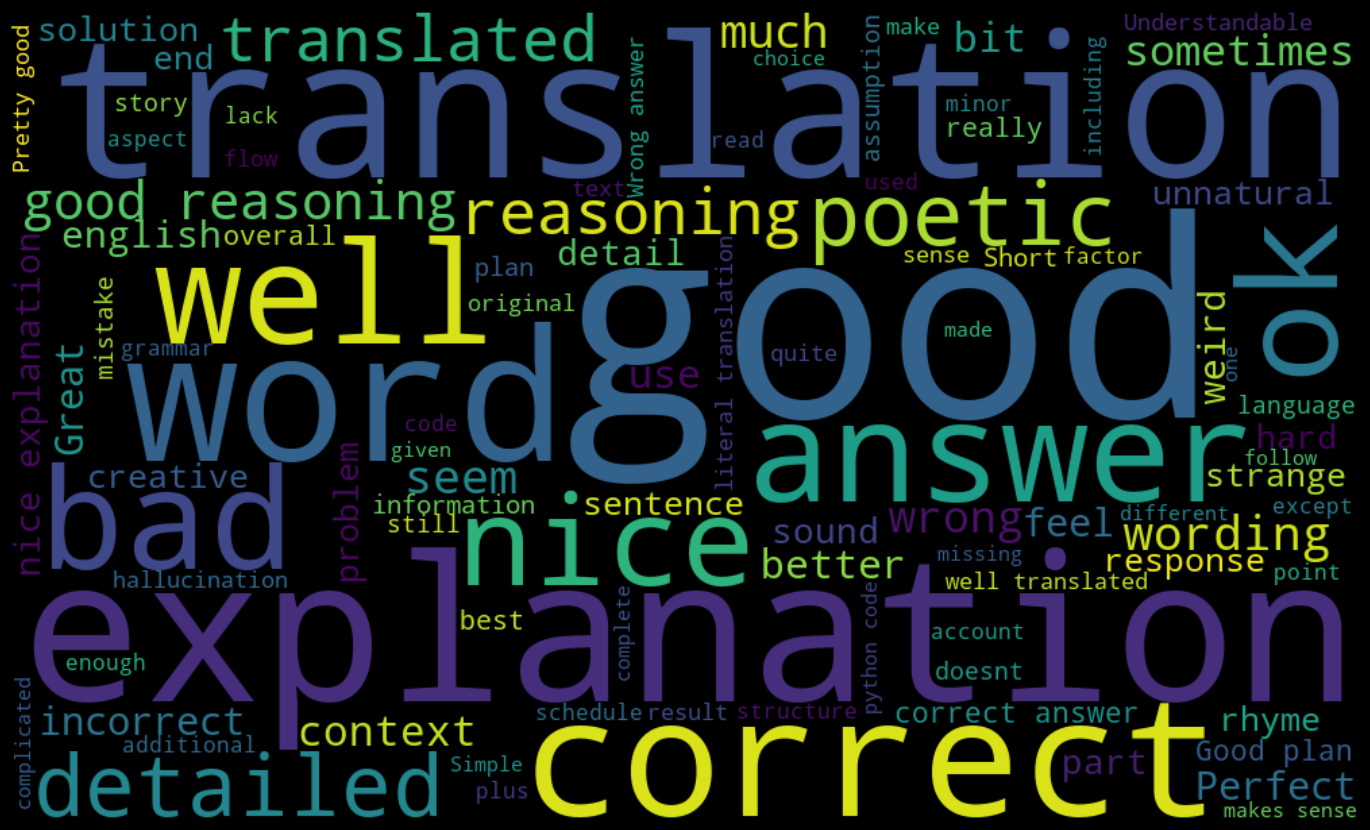

In [ ]:
viz_data = data.copy(deep=True)

viz_data['all_comments'] = viz_data[['Comments_Christine', 'Comment_Ansam', 'Comment_Adrian', 'Comment_Mike', 'Comment_Albin', 'Comment_Grzegorz']].agg(' '.join, axis=1)

# removing stop words for visualizations only because it reduced the polarity for some text
viz_data['all_comments'] = viz_data['all_comments'].apply(remove_stopwords)

# To join all
text = ''.join([post for post in viz_data['all_comments']])

for word_remove in ['No comment', 'comment', 'commentcomment']:
    text = text.replace(word_remove, '')

# generate word cloud 
stopwords = STOPWORDS
wordcloud = WordCloud(width=1000, height = 600, 
                      max_words = 100,
                      stopwords = stopwords,
                      background_color='black').generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')